In [ ]:
%matplotlib inline

In [ ]:
!pip install torchvision
!pip install tensorrt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for tensorrt: filename=tensorrt-8.6.1-py2.py3-none-any.whl size=16973 sha256=07593c7868cc3d180d70dd64818284e5c6b4886d39c6c4a2e3fba84353520346
  Stored in directory: /root/.cache/pip/wheels/6d/29/56/abdffd4c604f255b5254bef3f1c598ab7811ea020540599438
Successfully built tensorrt


In [ ]:
import torch
from torchvision.models import resnet18, ResNet18_Weights
model = resnet18(weights=ResNet18_Weights.DEFAULT)
data = torch.rand(1, 3, 64, 64)
labels = torch.rand(1, 1000)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 105MB/s]


In [ ]:
prediction = model(data) # forward pass

In [ ]:
loss = (prediction - labels).sum()
loss.backward() # backward pass

In [ ]:
optim = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)

In [ ]:
optim.step() #gradient descent

--------------




## Differentiation in Autograd
Let's take a look at how ``autograd`` collects gradients. We create two tensors ``a`` and ``b`` with
``requires_grad=True``. This signals to ``autograd`` that every operation on them should be tracked.




In [ ]:
import torch

a = torch.tensor([2., 3.], requires_grad=True)
b = torch.tensor([6., 4.], requires_grad=True)

We create another tensor ``Q`` from ``a`` and ``b``.

\begin{align}Q = 3a^3 - b^2\end{align}



In [ ]:
Q = 3*a**3 - b**2

Let's assume ``a`` and ``b`` to be parameters of an NN, and ``Q``
to be the error. In NN training, we want gradients of the error
w.r.t. parameters, i.e.

\begin{align}\frac{\partial Q}{\partial a} = 9a^2\end{align}

\begin{align}\frac{\partial Q}{\partial b} = -2b\end{align}


When we call ``.backward()`` on ``Q``, autograd calculates these gradients
and stores them in the respective tensors' ``.grad`` attribute.

We need to explicitly pass a ``gradient`` argument in ``Q.backward()`` because it is a vector.
``gradient`` is a tensor of the same shape as ``Q``, and it represents the
gradient of Q w.r.t. itself, i.e.

\begin{align}\frac{dQ}{dQ} = 1\end{align}

Equivalently, we can also aggregate Q into a scalar and call backward implicitly, like ``Q.sum().backward()``.




In [ ]:
external_grad = torch.tensor([1., 1.])
Q.backward(gradient=external_grad)

Gradients are now deposited in ``a.grad`` and ``b.grad``



In [ ]:
# check if collected gradients are correct
print(9*a**2 == a.grad)
print(-2*b == b.grad)

tensor([True, True])
tensor([True, True])


### Vector Calculus using ``autograd``

Mathematically, if you have a vector valued function
$\vec{y}=f(\vec{x})$, then the gradient of $\vec{y}$ with
respect to $\vec{x}$ is a Jacobian matrix $J$:

\begin{align}J
     =
      \left(\begin{array}{cc}
      \frac{\partial \bf{y}}{\partial x_{1}} &
      ... &
      \frac{\partial \bf{y}}{\partial x_{n}}
      \end{array}\right)
     =
     \left(\begin{array}{ccc}
      \frac{\partial y_{1}}{\partial x_{1}} & \cdots & \frac{\partial y_{1}}{\partial x_{n}}\\
      \vdots & \ddots & \vdots\\
      \frac{\partial y_{m}}{\partial x_{1}} & \cdots & \frac{\partial y_{m}}{\partial x_{n}}
      \end{array}\right)\end{align}

Generally speaking, ``torch.autograd`` is an engine for computing
vector-Jacobian product. That is, given any vector $\vec{v}$, compute the product
$J^{T}\cdot \vec{v}$

If $\vec{v}$ happens to be the gradient of a scalar function $l=g\left(\vec{y}\right)$:

\begin{align}\vec{v}
   =
   \left(\begin{array}{ccc}\frac{\partial l}{\partial y_{1}} & \cdots & \frac{\partial l}{\partial y_{m}}\end{array}\right)^{T}\end{align}

then by the chain rule, the vector-Jacobian product would be the
gradient of $l$ with respect to $\vec{x}$:

\begin{align}J^{T}\cdot \vec{v}=\left(\begin{array}{ccc}
      \frac{\partial y_{1}}{\partial x_{1}} & \cdots & \frac{\partial y_{m}}{\partial x_{1}}\\
      \vdots & \ddots & \vdots\\
      \frac{\partial y_{1}}{\partial x_{n}} & \cdots & \frac{\partial y_{m}}{\partial x_{n}}
      \end{array}\right)\left(\begin{array}{c}
      \frac{\partial l}{\partial y_{1}}\\
      \vdots\\
      \frac{\partial l}{\partial y_{m}}
      \end{array}\right)=\left(\begin{array}{c}
      \frac{\partial l}{\partial x_{1}}\\
      \vdots\\
      \frac{\partial l}{\partial x_{n}}
      \end{array}\right)\end{align}

This characteristic of vector-Jacobian product is what we use in the above example;
``external_grad`` represents $\vec{v}$.




## Computational Graph

Conceptually, autograd keeps a record of data (tensors) & all executed
operations (along with the resulting new tensors) in a directed acyclic
graph (DAG) consisting of
[Function](https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)_
objects. In this DAG, leaves are the input tensors, roots are the output
tensors. By tracing this graph from roots to leaves, you can
automatically compute the gradients using the chain rule.

In a forward pass, autograd does two things simultaneously:

- run the requested operation to compute a resulting tensor, and
- maintain the operation’s *gradient function* in the DAG.

The backward pass kicks off when ``.backward()`` is called on the DAG
root. ``autograd`` then:

- computes the gradients from each ``.grad_fn``,
- accumulates them in the respective tensor’s ``.grad`` attribute, and
- using the chain rule, propagates all the way to the leaf tensors.


<div class="alert alert-info"><h4>Note</h4><p>**DAGs are dynamic in PyTorch**
  An important thing to note is that the graph is recreated from scratch; after each
  ``.backward()`` call, autograd starts populating a new graph. This is
  exactly what allows you to use control flow statements in your model;
  you can change the shape, size and operations at every iteration if
  needed.</p></div>

### Exclusion from the DAG

``torch.autograd`` tracks operations on all tensors which have their
``requires_grad`` flag set to ``True``. For tensors that don’t require
gradients, setting this attribute to ``False`` excludes it from the
gradient computation DAG.

The output tensor of an operation will require gradients even if only a
single input tensor has ``requires_grad=True``.




In [ ]:
x = torch.rand(5, 5)
y = torch.rand(5, 5)
z = torch.rand((5, 5), requires_grad=True)

a = x + y
print(f"Does `a` require gradients? : {a.requires_grad}")
b = x + z
print(f"Does `b` require gradients?: {b.requires_grad}")

Does `a` require gradients? : False
Does `b` require gradients?: True


In [ ]:
import torch
from torch import nn
%pip install -U git+https://github.com/szagoruyko/pytorchviz.git@master
from torchviz import make_dot, make_dot_from_trace

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/szagoruyko/pytorchviz.git (to revision master) to /tmp/pip-req-build-86x87q9k
  Running command git clone --filter=blob:none --quiet https://github.com/szagoruyko/pytorchviz.git /tmp/pip-req-build-86x87q9k
  Resolved https://github.com/szagoruyko/pytorchviz.git to commit 0adcd83af8aa7ab36d6afd139cabbd9df598edb7
  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4972 sha256=c91c1877de43c28a1d26741ea96e17ba247b1b18ba736d5ac8dbfd1bcac21c9d
  Stored in directory: /tmp/pip-ephem-wheel-cache-uo5g7ibm/wheels/97/11/17/d09e895f9883bd50923ce86b249a31790356a1b88b280983d8
Successfully built torchviz


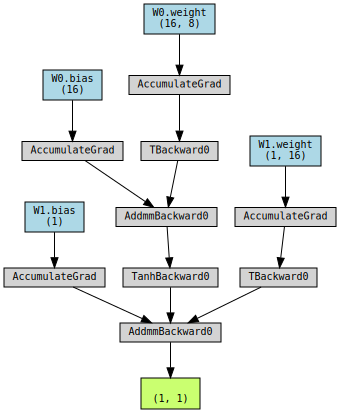

In [ ]:
model = nn.Sequential()
model.add_module('W0', nn.Linear(8, 16))
model.add_module('tanh', nn.Tanh())
model.add_module('W1', nn.Linear(16, 1))

x = torch.randn(1,8)

make_dot(model(x), params=dict(model.named_parameters()))

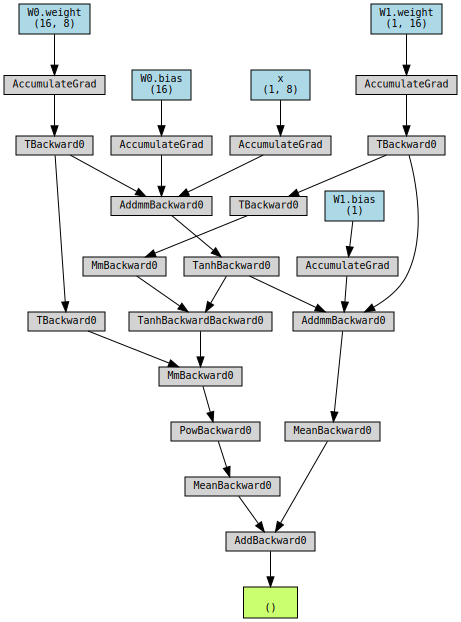

In [ ]:
x = torch.randn(1,8).requires_grad_(True)

def double_backprop(inputs, net):
    y = net(x).mean()
    grad,  = torch.autograd.grad(y, x, create_graph=True, retain_graph=True)
    return grad.pow(2).mean() + y

make_dot(double_backprop(x, model), params=dict(list(model.named_parameters()) + [('x', x)]))

In a NN, parameters that don't compute gradients are usually called **frozen parameters**.
It is useful to "freeze" part of your model if you know in advance that you won't need the gradients of those parameters
(this offers some performance benefits by reducing autograd computations).

In finetuning, we freeze most of the model and typically only modify the classifier layers to make predictions on new labels.
Let's walk through a small example to demonstrate this. As before, we load a pretrained resnet18 model, and freeze all the parameters.



In [ ]:
from torch import nn, optim

model = resnet18(weights=ResNet18_Weights.DEFAULT)

# Freeze all the parameters in the network
for param in model.parameters():
    param.requires_grad = False

Let's say we want to finetune the model on a new dataset with 10 labels.
In resnet, the classifier is the last linear layer ``model.fc``.
We can simply replace it with a new linear layer (unfrozen by default)
that acts as our classifier.



In [ ]:
model.fc = nn.Linear(512, 10)

Now all parameters in the model, except the parameters of ``model.fc``, are frozen.
The only parameters that compute gradients are the weights and bias of ``model.fc``.



In [ ]:
# Optimize only the classifier
optimizer = optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)

Notice although we register all the parameters in the optimizer,
the only parameters that are computing gradients (and hence updated in gradient descent)
are the weights and bias of the classifier.

The same exclusionary functionality is available as a context manager in
[torch.no_grad()](https://pytorch.org/docs/stable/generated/torch.no_grad.html)_




In [ ]:
x = torch.randn(5, requires_grad=True)
y = x.pow(2)
print(x.equal(y.grad_fn._saved_self))  # True
print(x is y.grad_fn._saved_self)  # True

True
True


In [ ]:
x = torch.randn(5, requires_grad=True)
y = x.exp()
print(y.equal(y.grad_fn._saved_result))  # True
print(y is y.grad_fn._saved_result)  # False

True
False


In [ ]:
# Define a train function to be used in different threads
import threading

def train_fn():
    x = torch.ones(5, 5, requires_grad=True)
    # forward
    y = (x + 3) * (x + 4) * 0.5
    # backward
    y.sum().backward()
    # potential optimizer update


# User write their own threading code to drive the train_fn
threads = []
for _ in range(10):
    p = threading.Thread(target=train_fn, args=())
    p.start()
    threads.append(p)

for p in threads:
    p.join()

print(p)

<Thread(Thread-40 (train_fn), stopped 140352995669760)>


--------------


